# [프로젝트2] 지도학습 기반 모델 학습 및 평가


---

# 프로젝트 목표
---
- 지도학습 기반 머신러닝 모델을 학습하는 과정
- 평가 지표 설명 및 적용

# 프로젝트 목차
---

1. 데이터 읽기
2. 평가 지표
3. Decision Tree 학습 및 평가
4. 최적의 모델 파라미터 탐색
5. 최적의 모델 파라미터 탐색 후 머신러닝 모델 학습
6. 평가 결과 비교

# 프로젝트 개요
---

지도학습 기반 머신러닝 모델을 학습하는 방법과 파라미터 탐색 방법을 배우고 검증 방법을 배웁니다. 

# 1. 데이터 읽기
---

탐색적 자료 분석 및 데이터 전처리 과정에서 저장한 학습 및 검증 데이터를 불러옵니다.

## 1.1 라이브러리 불러오기
---

학습 및 평가와 결과 비교를 위해 시각화를 사용하기 위한 라이브러리를 불러옵니다.

In [1]:
import os
import warnings  # 경고문 무시를 위한 라이브러리
from collections import defaultdict  # 결과 저장을 위한 dictionary type

import lightgbm as lgb  # LightGBM 모델
import matplotlib.pyplot as plt  # 시각화
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb  # XGBoost 모델

# Random Forest, Extra Tree 모델
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

# 평가 지표
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# 파라미터 탐색을 위한 Cross Validation
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # Decision Tree 모델

warnings.filterwarnings(action="ignore")

# 2. 평가 지표
---

<p align="center">
    <img width="500" src="./assets/confusion_matrix.png">
</p>

<p align="center">
    <img width="700" src="./assets/auroc.gif">
</p>

분류 문제에서 머신러닝 모델의 성능을 평가하기 위한 지표로는 아래와 같이 다섯 가지 평가지표를 사용합니다.  

1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. AUROC

여기서 F1 Score는 Precision과 Recall의 조화평균이고 AUROC는 위 그림에서 곡선 아래 면적의 넓이를 의미합니다.  
AUROC는 0.5에서 1 사이 값을 가지며 나머지는 모두 0에서 1 사이의 값을 가집니다.  
다섯 가지 평가지표 모두 높을 수록 모델의 예측이 정확하다는 것을 의미합니다.  

위 그림에서 AUROC에 하여 threshold에 따라 변화하는 confusion matrix의 모습을 확인할 수 있습니다.  
AUROC를 제외한 네 가지 평가지표는 모두 최적의 threshold를 탐색하여 평가할 필요가 있습니다.  
따라서 이번 실습에서도 AUROC의 x/y 축이 되는 False Positive Ratio(FPR)과 True Positive Ratio(TPR)을 통해 두 차이(TPR-FPR)가 가장 큰 threshold를 최적의 threshold로 사용하여 다른 네 가지 평가지표를 계산합니다.

탐색적 자료 분석 및 데이터 전처리 과정에서 저장한 학습 및 검증 데이터를 불러옵니다.

In [2]:
datadir = '/mnt/elice/dataset'

df_train = pd.read_csv(os.path.join(datadir, 'train.csv'))
df_val = pd.read_csv(os.path.join(datadir, 'validation.csv'))

print('df_train.shape: ',df_train.shape)
print('df_val.shape: ',df_val.shape)

df_train.shape:  (31423, 120)
df_val.shape:  (13468, 120)


학습에 사용하지 않는 변수를 제외합니다.

In [3]:
remove_features = ['No.', 'LOT_ID', 'WF_ID', 'GRADE_CD', 'Train/Test']
df_train = df_train.drop(remove_features, axis=1)
df_val = df_val.drop(remove_features, axis=1)

print('df_train.shape: ',df_train.shape)
print('df_val.shape: ',df_val.shape)

df_train.shape:  (31423, 115)
df_val.shape:  (13468, 115)


학습 및 검증 데이터를 독립변수(`X`)와 목표변수(`y`) 데이터로 분리합니다.

In [4]:
target_name = 'PKT_Y'
X_train = df_train.drop(target_name, axis=1).values
y_train = df_train[target_name].values

X_val = df_val.drop(target_name, axis=1).values
y_val = df_val[target_name].values

# 3. Decision Tree 학습 및 평가
---

지도학습 방식 머신러닝 모델 중 Decision Tree 모델을 사용하여 코드를 통해 학습하는 방법과 예측하는 방법을 배웁니다.

In [5]:
model_name = 'Decision Tree'
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

학습된 모델을 통해 예측하기 위해서는 `predict` method를 사용합니다.  
`predict`를 사용하여 예측한 결과는 binary classification 이기 때문에 0 또는 1의 결과를 반환합니다.

In [6]:
pred_dt = model_dt.predict(X_val)
pred_dt

array([1., 0., 0., ..., 1., 1., 0.])

만약 각 class 별 확률을 반환하고자 한다면 `predict_proba` method를 사용합니다.  

In [7]:
prob_dt = model_dt.predict_proba(X_val)

In [8]:
prob_dt

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

반환된 class 별 확률의 분포를 시각화하여 확인합니다.

In [9]:
r_dt = pd.DataFrame({'y_true': y_val, 'y_prob': prob_dt[:,1]})

<Axes: xlabel='y_prob', ylabel='Density'>

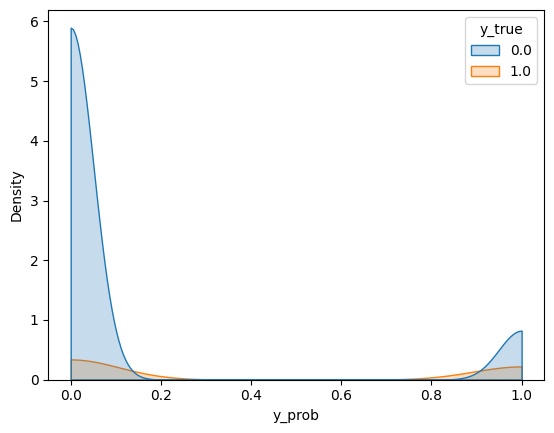

In [10]:
sns.kdeplot(x='y_prob', hue='y_true', fill=True, cut=0, data=r_dt)

Class 별 확률을 통해 ROC curve를 그려서 확인해봅니다.  
ROC curve는 threshold 마다 발생하는 TPR과 FPR의 결과 입니다. 따라서 threshold에 의존하지 않는 모델의 정확도를 판단할 수 있습니다.

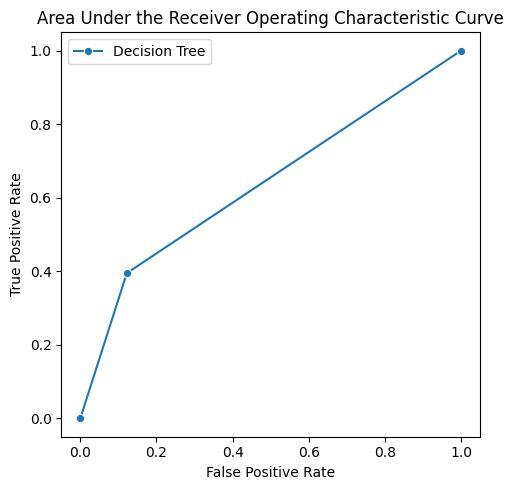

In [11]:
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=prob_dt[:,1])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.lineplot(x=fpr, y=tpr, marker='o', label=model_name, ax=ax)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Area Under the Receiver Operating Characteristic Curve')
plt.tight_layout()
plt.show()

ROC curve에 사용되는 True Positive Rate(TPR)과 False Positive Rate(FPR)을 사용하여 최적의 threshold를 탐색할 수 있습니다.  
TPR-FPR을 통해 두 차이가 가장 큰 지점에서의 threshold를 최적의 threshold로 판단하고 이를 통해 다른 평가지표를 계산합니다.

In [12]:
best_threshold = thresholds[np.argmax(tpr - fpr)]
best_threshold

np.float64(1.0)

In [13]:
pred_dt = (prob_dt[:,1] >= best_threshold).astype(int)

In [14]:
accuracy = accuracy_score(y_true=y_val, y_pred=pred_dt)
precision = precision_score(y_true=y_val, y_pred=pred_dt)
recall = recall_score(y_true=y_val, y_pred=pred_dt)
f1 = f1_score(y_true=y_val, y_pred=pred_dt)
roc_auc = roc_auc_score(y_true=y_val, y_score=prob_dt[:,1])

metrics_dt = {
    'Model'     : f'{model_name}',    
    'Accuracy'  : accuracy,
    'Precision' : precision,
    'Recall'    : recall,
    'F1 Score'  : f1,
    'AUROC'     : roc_auc
}
metrics_dt

{'Model': 'Decision Tree',
 'Accuracy': 0.8056875556875557,
 'Precision': np.float64(0.3623518687329079),
 'Recall': np.float64(0.3949329359165425),
 'F1 Score': np.float64(0.3779415260280485),
 'AUROC': np.float64(0.636401430856569)}

# 4. 최적의 모델 파라미터 탐색

<p align="center">
    <img width="400" src="./assets/grid_search.png">
</p>

이번 실습에서 모델 파라미터를 탐색하기 위한 방법으로는 Grid Search를 사용합니다.  
Grid Search는 가능한 모든 조합에 대하여 모델을 평가하고 가장 높은 성능을 나타내는 파라미터를 사용하는 방법입니다.

<p align="center">
    <img width="700" src="./assets/cross_validation.png">
</p>

모델 파라미터를 검증하는 과정에서는 Cross Validation이 사용됩니다.  

1. 그림과 같이 학습 데이터를 K개의 subset(또는 Fold)로 분리합니다.  
2. 다음으로는 모델의 파라미터를 지정한 후 K-1개의 학습 데이터와 하나의 검증 데이터를 사용하여 모델을 K개 학습합니다.
3. 학습된 K개 모델을 통해 검증 데이터를 통해 평가한 평균 점수를 계산합니다.


최적의 모델 파라미터는 탐색하고자 하는 모든 경우의 수에 따라 Cross Validation과 같은 검증 과정을 거칩니다.
결과적으로 가장 높은 평균 점수에 해당하는 모델 파라미터 조합을 최적의 파라미터로 가정하여 전체 학습데이터를 학습합니다.

---

GridSearchCV를 통해 앞서 언급한 Grid Search 방식과 Cross Validation을 함께 적용할 수 있습니다.  
여기서 K-fold는 5로 설정합니다. 파라미터 `cv`를 크게 설정할수록 실행 시간이 길어집니다.

다음으로는 탐색할 모델의 파라미터 조합을 정의합니다. 이때로 마찬가지로 조합의 수가 많을 수록 실행 시간이 길어집니다.

In [15]:
# GridSearchCV를 사용하여 최적의 파라미터 찾기
dt_params = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

clf = GridSearchCV(
    estimator          = DecisionTreeClassifier(), # 지도학습 모델
    param_grid         = dt_params, # 탐색할 파라미터 조랍
    cv                 = 5, # K-fold
    scoring            = 'f1', # best model을 판단하기 위해 기준으로 사용할 평가 지표
    return_train_score = True, # 학습 성능 반환 여부
    verbose            = 1 # 실행 과정을 보여주는 정도 1~3까지 있으며 클수록 더 자세히 실행 과정이 출력됩니다.
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5]},
             return_train_score=True, scoring='f1', verbose=1)

GridSearchCV를 통해 계산된 파라미터 별 점수는 `cv_results_`에 저장되어 있습니다. 이를 통해 결과를 살펴봅니다.
여기서 score는 앞서 정의한 best model을 판단하기 위해 기준으로 사용할 평가 지표 입니다. 위에서는 'f1 score'를 지정하였기 때문에 반환된 score는 모두 'f1 score' 값입니다.

In [16]:
# 세부 결과 저장
detailed_results = {
    'Params'           : clf.cv_results_['params'],
    'Mean Test Score'  : clf.cv_results_['mean_test_score'],
    'Std Test Score'   : clf.cv_results_['std_test_score'],
    'Mean Train Score' : clf.cv_results_['mean_train_score'],
    'Std Train Score'  : clf.cv_results_['std_train_score']
}
detailed_results

{'Params': [{'max_depth': None, 'min_samples_split': 2},
  {'max_depth': None, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_split': 2},
  {'max_depth': 5, 'min_samples_split': 5},
  {'max_depth': 10, 'min_samples_split': 2},
  {'max_depth': 10, 'min_samples_split': 5}],
 'Mean Test Score': array([0.35257457, 0.34402472, 0.20338768, 0.20338768, 0.2778181 ,
        0.27644044]),
 'Std Test Score': array([0.01769174, 0.02156635, 0.01760656, 0.01760656, 0.0216364 ,
        0.01982251]),
 'Mean Train Score': array([1.        , 0.89619166, 0.21745669, 0.21745669, 0.39903017,
        0.39499986]),
 'Std Train Score': array([0.        , 0.00188186, 0.02376785, 0.02376785, 0.00879746,
        0.00667334])}

In [17]:
pd.DataFrame(detailed_results).sort_values('Mean Test Score')

,Params,Mean Test Score,Std Test Score,Mean Train Score,Std Train Score
3,"{'max_depth': 5, 'min_samples_split': 5}",0.203388,0.017607,0.217457,0.023768
2,"{'max_depth': 5, 'min_samples_split': 2}",0.203388,0.017607,0.217457,0.023768
5,"{'max_depth': 10, 'min_samples_split': 5}",0.276440,0.019823,0.395000,0.006673
4,"{'max_depth': 10, 'min_samples_split': 2}",0.277818,0.021636,0.399030,0.008797
1,"{'max_depth': None, 'min_samples_split': 5}",0.344025,0.021566,0.896192,0.001882
0,"{'max_depth': None, 'min_samples_split': 2}",0.352575,0.017692,1.000000,0.000000


최적의 모델 성능에 대한 파라미터는 `best_params_`에 저장되어 있습니다.  
이 파라미터를 사용하여 모델을 새롭게 정의한 후 전체 데이터에 학습합니다.

In [18]:
# 최적의 모델로 예측
clf.best_params_

{'max_depth': None, 'min_samples_split': 2}

In [19]:
model_dt_best = DecisionTreeClassifier(**clf.best_params_)
model_dt_best.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
prob_dt_best = model_dt_best.predict_proba(X_val)
r_dt = pd.DataFrame({'y_true': y_val, 'y_prob': prob_dt_best[:,1]})

반환된 class 별 확률의 분포를 시각화하여 확인합니다.

<Axes: xlabel='y_prob', ylabel='Density'>

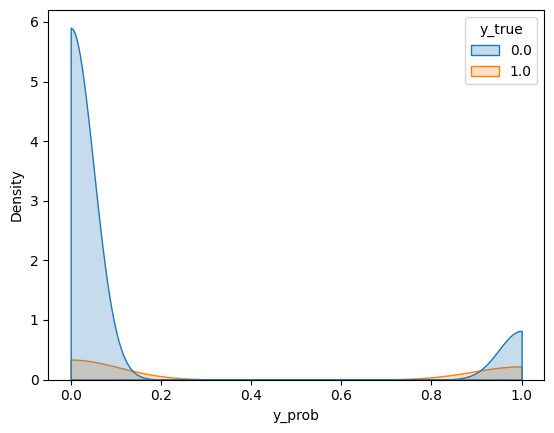

In [21]:
sns.kdeplot(x='y_prob', hue='y_true', fill=True, cut=0, data=r_dt)

Class 별 확률을 통해 ROC curve를 그려서 확인해봅니다.  

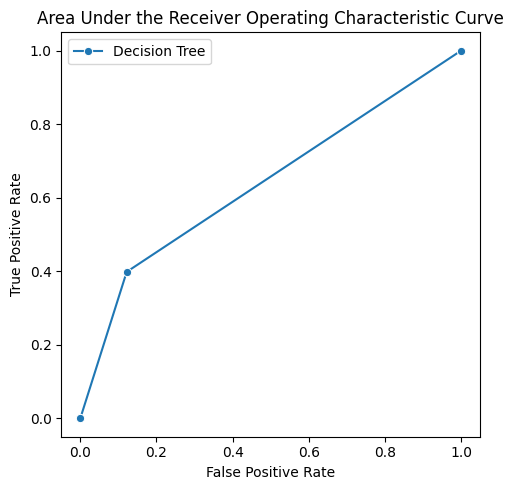

In [22]:
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=prob_dt_best[:,1])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.lineplot(x=fpr, y=tpr, marker='o', label=model_name, ax=ax)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Area Under the Receiver Operating Characteristic Curve')
plt.tight_layout()
plt.show()

이전에 결과와 동일한 이유는 Decision Tree의 기본값(default)로 지정되어있는 파라미터가 최적의 파라미터가 되었기 때문입니다.

In [23]:
best_threshold = thresholds[np.argmax(tpr - fpr)]
best_threshold

np.float64(1.0)

In [24]:
pred_dt_best = (prob_dt[:,1] >= best_threshold).astype(int)

In [25]:
accuracy = accuracy_score(y_true=y_val, y_pred=pred_dt_best)
precision = precision_score(y_true=y_val, y_pred=pred_dt_best)
recall = recall_score(y_true=y_val, y_pred=pred_dt_best)
f1 = f1_score(y_true=y_val, y_pred=pred_dt_best)
roc_auc = roc_auc_score(y_true=y_val, y_score=prob_dt_best[:,1])

metrics_dt_best = {
    'Model'     : f'{model_name} (CV)',
    'Accuracy'  : accuracy,
    'Precision' : precision,
    'Recall'    : recall,
    'F1 Score'  : f1,
    'AUROC'     : roc_auc
}
metrics_dt_best

{'Model': 'Decision Tree (CV)',
 'Accuracy': 0.8056875556875557,
 'Precision': np.float64(0.3623518687329079),
 'Recall': np.float64(0.3949329359165425),
 'F1 Score': np.float64(0.3779415260280485),
 'AUROC': np.float64(0.6382710765012145)}

In [26]:
results = defaultdict(list)
metric_names = [
    'Model',
    'Accuracy',
    'Precision',
    'Recall',
    'F1 Score',
    'AUROC'
]
metric_results = [metrics_dt, metrics_dt_best]

for name in metric_names:
    for r in metric_results:
        results[name].append(r[name])

In [27]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,Decision Tree,0.805688,0.362352,0.394933,0.377942,0.636401
1,Decision Tree (CV),0.805688,0.362352,0.394933,0.377942,0.638271


# 5. 최적의 모델 파라미터 탐색 후 머신러닝 모델 학습
---


코드를 단순화하기 위해 함수를 작성하여 활용합니다.

`calc_metrics`에서는 앞선 결과 지표와 같이 최적의 파라미터는 탐색하는 내용을 추가하여 다섯 가지 평가지표를 산출합니다.

`grid_search`는 모델 정보(모델 및 파라미터 조합)을 입력하여 탐색한 후 최적의 모델로 산출된 결과를 반환합니다.

In [28]:
def calc_metrics(y_true, y_prob):
    
    # AUROC info
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_prob[:,1])
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    
    roc_info = {
        'FPR'            : fpr,
        'TPR'            : tpr,
        'best_threshold' : best_threshold
    }
    
    # calculate metrics
    y_pred = (y_prob[:,1] >= best_threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob[:,1])
    
    metrics = {
        'Accuracy'  : accuracy,
        'Precision' : precision,
        'Recall'    : recall,
        'F1 Score'  : f1,
        'AUROC'     : roc_auc
    }
    
    return metrics, roc_info

In [29]:
def grid_search(
    model_info: dict, 
    X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray
):
    # GridSearchCV를 사용하여 최적의 파라미터 찾기
    clf = GridSearchCV(
        estimator          = model_info['model'](), 
        param_grid         = model_info['params'], 
        cv                 = 5, 
        scoring            = 'f1', 
        return_train_score = True,
        verbose            = 1
    )
    clf.fit(X_train, y_train)

    # 최적의 파라미터로 전체 학습 데이터에 학습
    best_model = model_info['model'](**clf.best_params_)
    best_model.fit(X_train, y_train)
    
    # 평가
    y_prob = best_model.predict_proba(X_val)
    
    # 평가지표 계산
    metrics, roc_info = calc_metrics(y_true=y_val, y_prob=y_prob)

    # 결과 저장
    results = {'Best Params': clf.best_params_, 'metrics': metrics, 'roc_info': roc_info}

    return results

사용할 머신러닝 모델과 모델 별 파라미터 조합을 지정합니다. 

아래 표는 모델 별 일부 파라미터에 대한 설명입니다. 모델 별 전체 파라미터에 대한 설명은 링크를 통해 확인할 수 있습니다.

1. Decision Tree [ [doc](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) ]

| Parameter               | Type                                                | Description                                                                 | Default |
|-------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|---------|
| criterion               | {'gini', 'entropy', 'log_loss'}                     | 최적의 분할을 위해 사용할 기준입니다. 'gini', 'entropy', 'log_loss' 중 하나를 선택할 수 있습니다. | 'gini'  |
| splitter                | {'best', 'random'}                                  | 분할 방법을 선택합니다. 'best'는 최적의 분할을, 'random'은 무작위 분할을 의미합니다.         | 'best'  |
| max_depth               | int, default=None                                   | 트리의 최대 깊이입니다. None이면 리프 노드가 순수해질 때까지 분할합니다.                     | None    |
| min_samples_split       | int or float, default=2                             | 내부 노드를 분할하기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.     | 2       |
| min_samples_leaf        | int or float, default=1                             | 리프 노드가 되기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.         | 1       |
| max_features            | int, float or {'auto', 'sqrt', 'log2'}, default=None| 최적의 분할을 위해 고려할 최대 특징 수입니다.                                    | None    |
| max_leaf_nodes          | int, default=None                                   | 리프 노드의 최대 수입니다.                                                       | None    |
| min_impurity_decrease   | float, default=0.0                                  | 분할이 이루어질 최소 불순도 감소량입니다.                                            | 0.0     |


2. Random Forest [ [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ]

| Parameter               | Type                                                | Description                                                                 | Default |
|-------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|---------|
| n_estimators            | int, default=100                                    | 포레스트에 있는 트리의 수입니다.                                                | 100     |
| criterion               | {'gini', 'entropy', 'log_loss'}                     | 최적의 분할을 위해 사용할 기준입니다. 'gini', 'entropy', 'log_loss' 중 하나를 선택할 수 있습니다. | 'gini'  |
| min_samples_split       | int or float, default=2                             | 내부 노드를 분할하기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.     | 2       |
| min_samples_leaf        | int or float, default=1                             | 리프 노드가 되기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.         | 1       |
| max_features            | int, float or {'auto', 'sqrt', 'log2'}, default='sqrt'| 최적의 분할을 위해 고려할 최대 특징 수입니다.                                    | 'sqrt'  |
| max_leaf_nodes          | int, default=None                                   | 리프 노드의 최대 수입니다.                                                       | None    |
| min_impurity_decrease   | float, default=0.0                                  | 분할이 이루어질 최소 불순도 감소량입니다.                                            | 0.0     |
| oob_score               | bool, default=False                                 | 외부 샘플을 사용하여 점수를 계산할지 여부입니다.                                         | False   |
| class_weight            | dict, list of dict or 'balanced', default=None      | 클래스의 가중치를 설정합니다.                                                     | None    |
| max_samples             | float, default=None                                 | 훈련에 사용할 샘플 비율입니다.                                                     | None    |


3. Extra Tree [ [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) ]

| Parameter               | Type                                                | Description                                                                 | Default |
|-------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|---------|
| n_estimators            | int, default=100                                    | 포레스트에 있는 트리의 수입니다.                                                | 100     |
| criterion               | {'gini', 'entropy', 'log_loss'}                     | 최적의 분할을 위해 사용할 기준입니다. 'gini', 'entropy', 'log_loss' 중 하나를 선택할 수 있습니다. | 'gini'  |
| max_depth               | int, default=None                                   | 트리의 최대 깊이입니다. None이면 리프 노드가 순수해질 때까지 분할합니다.                     | None    |
| min_samples_split       | int or float, default=2                             | 내부 노드를 분할하기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.     | 2       |
| min_samples_leaf        | int or float, default=1                             | 리프 노드가 되기 위한 최소 샘플 수입니다. int는 샘플 수, float는 비율을 의미합니다.         | 1       |
| min_weight_fraction_leaf| float, default=0.0                                  | 리프 노드의 최소 가중치 분수입니다.                                                | 0.0     |
| max_features            | int, float or {'auto', 'sqrt', 'log2'}, default='sqrt'| 최적의 분할을 위해 고려할 최대 특징 수입니다.                                    | 'sqrt'  |
| max_leaf_nodes          | int, default=None                                   | 리프 노드의 최대 수입니다.                                                       | None    |


4. LightGBM [ [doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) ]

| Parameter               | Type                                                | Description                                                                 | Default |
|-------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|---------|
| boosting_type           | str, default='gbdt'                                 | 부스팅 유형입니다. 'gbdt', 'dart', 'goss' 중 하나를 선택할 수 있습니다.            | 'gbdt'  |
| num_leaves              | int, default=31                                     | 하나의 트리가 가질 수 있는 최대 리프 수입니다.                                    | 31      |
| max_depth               | int, default=-1                                     | 트리의 최대 깊이입니다. -1이면 제한이 없습니다.                                     | -1      |
| learning_rate           | float, default=0.1                                  | 학습률입니다.                                                                  | 0.1     |
| n_estimators            | int, default=100                                    | 부스팅 단계를 수행할 트리의 수입니다.                                             | 100     |
| objective               | str, callable or None, default=None                 | 학습 목표 함수입니다.                                                            | None    |
| class_weight            | dict, list of dict or 'balanced', default=None      | 클래스의 가중치를 설정합니다.                                                     | None    |
| reg_alpha               | float, default=0.0                                  | L1 정규화에 사용할 항입니다.                                                      | 0.0     |
| reg_lambda              | float, default=0.0                                  | L2 정규화에 사용할 항입니다.                                                      | 0.0     |


5. XGBoost [ [doc](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) ]

| Parameter               | Type                                                | Description                                                                 | Default |
|-------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|---------|
| max_depth               | int, default=6                                      | 트리의 최대 깊이입니다.                                                       | 6       |
| learning_rate           | float, default=0.3                                  | 학습률입니다.                                                                  | 0.3     |
| n_estimators            | int, default=100                                    | 부스팅 단계를 수행할 트리의 수입니다.                                             | 100     |
| objective               | str or callable, default=None                       | 학습 목표 함수입니다.                                                            | None    |
| booster                 | str, default='gbtree'                               | 부스터 타입입니다.                                                               | 'gbtree'|
| tree_method             | str, default=None                                   | 트리 구성 방법입니다.                                                             | None    |
| n_jobs                  | int, default=1                                      | 작업을 병렬로 실행하기 위한 CPU 코어 수입니다.                                         | 1       |




#### [TODO] 각 모델이 탐색하고자 하는 파라미터 조합을 입력해서 파라미터 탐색 그리드를 정의합니다.
- 실습 해설 영상의 파라미터 조합을 사용하셔도 되고, 여러분이 추가로 파라미터 조합을 선택하셔도 됩니다.

In [36]:
# 모델 및 파라미터 그리드 정의
model_info = {
    'Decision Tree': {
        'model': DecisionTreeClassifier,
        'params': {
            'max_depth': [None, 5],
            'min_samples_split': [2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier,
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 5],
            'min_samples_split': [2, 5]
        }
    },
    'Extra Tree': {
        'model': ExtraTreesClassifier,
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier,
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [31, 50],
            'min_samples_split': [0.01, 0.1, 0.3]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier,
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6, 10],
            'min_samples_split': [0.01, 0.1, 0.3]
        }
    }
}

이 과정에서 앞서 파라미터 조합에 따라 시간이 5분 이상 소요될 수 있습니다.

In [37]:
results = {}
for name, info in model_info.items():
    print(f'\n{name}')
    results[name] = grid_search(
        model_info = info,
        X_train    = X_train,
        y_train    = y_train,
        X_val      = X_val,
        y_val      = y_val
    )


Decision Tree
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Extra Tree
Fitting 5 folds for each of 12 candidates, totalling 60 fits

LightGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3758, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10086
[LightGBM] [Info] Number of data points in the train set: 25138, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149495 -> initscore=-1.738569
[LightGBM] [Info] Start training from score -1.738569
[LightGBM] [Warning] Unknown pa

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3758, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10086
[LightGBM] [Info] Number of data points in the train set: 25138, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149495 -> initscore=-1.738569
[LightGBM] [Info] Start training from score -1.738569
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3758, number of negative: 21380
[LightGBM] [Info] Auto-

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3758, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10020
[LightGBM] [Info] Number of data points in the train set: 25138, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149495 -> initscore=-1.738569
[LightGBM] [Info] Start training from score -1.738569
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parame

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3758, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10080
[LightGBM] [Info] Number of data points in the train set: 25138, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149495 -> initscore=-1.738569
[LightGBM] [Info] Start training from score -1.738569
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parame

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3759, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10036
[LightGBM] [Info] Number of data points in the train set: 25139, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149529 -> initscore=-1.738303
[LightGBM] [Info] Start training from score -1.738303
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parame

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 3759, number of negative: 21380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10027
[LightGBM] [Info] Number of data points in the train set: 25139, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149529 -> initscore=-1.738303
[LightGBM] [Info] Start training from score -1.738303
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parame

# 6. 평가 결과 비교

다섯 가지 모델에 대하여 각각에 대한 최적의 성능을 비교하였을 때 Random Forest가 `F1 Score` 기준 가장 좋은 성능을 나타냅니다.  
파라미터 탐색에 사용한 조합에 따라 실습에서의 결과와 상이할 수 있습니다.

In [38]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC']
df_figure = defaultdict(list)
for model_name, r in results.items():
    df_figure['Model'].append(model_name)
    for m in metrics:
        df_figure[m].append(r['metrics'][m])

In [39]:
df_figure = pd.DataFrame(df_figure).sort_values('F1 Score')
df_figure

,Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,Decision Tree,0.808509,0.370064,0.400397,0.384634,0.640312
3,LightGBM,0.756386,0.321910,0.569300,0.411269,0.729824
2,Extra Tree,0.751114,0.321609,0.599603,0.418661,0.745371
4,XGBoost,0.798560,0.375178,0.522603,0.436786,0.727543
1,Random Forest,0.796184,0.377837,0.562345,0.451986,0.762470


seaborn의 `catplot`을 사용하여 다섯 가지 모델에 대한 평가 지표별 결과를 막대그래프로 시각화하여 비교합니다.
- 여러분의 시각화 결과는 영상의 시각화 결과와 조금 다를 수 있습니다. 대부분의 경우는 Decision Tree 모델의 AUROC 값이 제일 작습니다.

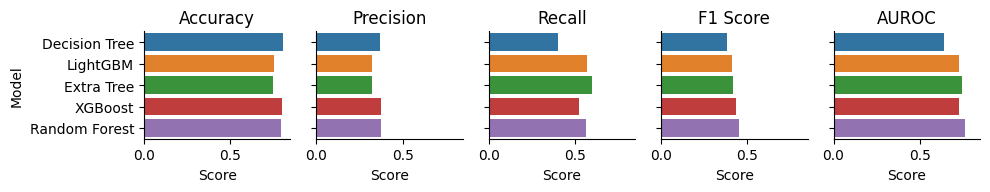

In [40]:
g = sns.catplot(
    x = 'Score',    
    y = 'Model',
    col = 'level_1',
    kind = 'bar',
    palette = sns.color_palette(),
    height = 2,
    aspect = 1.,
    data = df_figure.set_index('Model').stack().reset_index(name='Score') 
)

for ax in g.fig.axes:
    sub_title = ax.title._text

    col_name = sub_title.split('=')[1].strip()
    new_title = f'{col_name}'

    ax.set_title(new_title)
plt.show()

seaborn의 `lineplot`을 사용하여 모델 별 FPR과 TPR 결과를 시각화합니다. 이때 곡선 아래의 면적 넓이가 넓을 수록 모델의 성능이 우수함을 의미합니다.

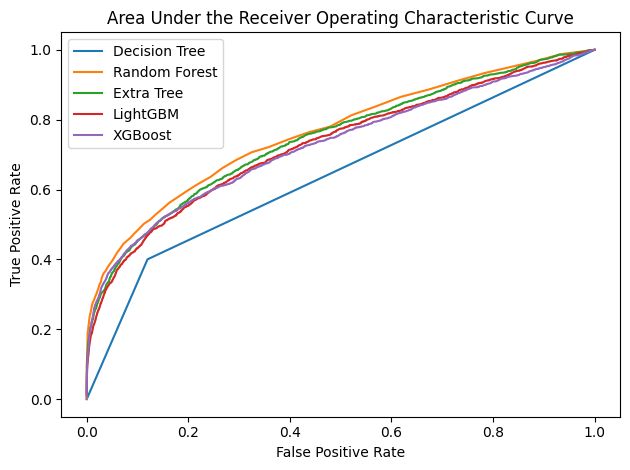

In [41]:
for i, (model_name, r) in enumerate(results.items()):
    sns.lineplot(
        x     = r['roc_info']['FPR'],
        y     = r['roc_info']['TPR'],
        color = sns.color_palette()[i],
        label = model_name
    )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under the Receiver Operating Characteristic Curve')
plt.tight_layout()
plt.show()